In [1]:
## ISOTOMICS CODE
## Written by tcsernica and szeichner
## Last update : February 5, 2026

#IMPORT DEPENDENCIES
import sys; sys.path.insert(0, 'isotomics')
import os
import copy
import json
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import date

#IMPORT ISOTOMICS RELATED DATA
cwd = Path().resolve()
sys.path.insert(0, str(cwd))
from isotomics import fragmentAndSimulate as fas
from isotomics import calcIsotopologues as ci
from isotomics import readInput as ri
from isotomics import solveSystem as ss
from isotomics import basicDeltaOperations as op
from isotomics import organizeData
from isotomics import dataAnalyzerMNIsoX as dA
from isotomics import dataScreenIsoX as dataScreen
from isotomics import readCSVAndSimulate as sim
from isotomics import spectrumVis
from isotomics import solveExperimentalData

In [2]:
today = date.today()

#SET GLOBAL PARAMETERS

#STEP #1: you need to set up a csv file for your molecule based on the stochiometry of the 
#fragment and molecular ion. See Csernica and Eiler, 2023 for explanation of how to set this up. 
#Also, see example files in the repository.
MOLECULE_INPUT_PATH = "Input Data/Example_Molecule_Input.csv"

MOLECULAR_AVERAGE_TYPE = '13C/Unsub' #This is the type of ratio that is used to compute the "U Value" which translates M+1 relative abundance space into site-specific values. The value can come from orbitrap or from EA. See Csernica and Eiler, 2023 for more explanation. 

#Define details regarding your sample, which should come from external measurements.
MOLECULAR_AVERAGE_SAMPLE_COMPOSITION, MOLECULAR_AVG_SAMPLE_ERROR = -0.8, 0.1 #d13C value and error (from EA)
                                                                #You can also get this parameter from a direct Orbitrap measurement of 13C/Unsub (or other ratios, 15N for example). In that case, set both of these to None

#Define details regarding your standard. These values could be known externally or could be a guess. In this case, they correspond to the order:
# Calphabeta Ccarboxyl Ocarboxyl Namine Hretained Hlost
#for alanine in the Weiss et al. paper. In that case, the carbon values were known but the others were not, so they were set to 0. 
STANDARD_DELTA_APPROX = [-11.9,-9.95,0,0,0,0] #these values should be in an array format that is the the same length 
                                                        # of your # of table rows (i.e., atomic sites constrained).
                                                        # this data could come from NMR, or be a guess. To model how that guess affects your 
                                                        # results, proceed to next code block.

In [3]:
#STEP 2: MODELING A SYSTEM WITH SIMULATED DATA. 

#The idea behind this section is--before you run any experimental data, take a look and see how well your system can be solved in principle, and make sure that the quantities you have measured make sense for the system. 

#Define deltas for samples and standards to model a simple data set
#This part is very confusing for new users--why are there two sets of standard values, STANDARD_DELTA_APPROX above and STD_DELTAS here? 
#The difference is, STD_DELTAS are the true standard values. E.g., if I hand you an alanine standard, there is some isotopic distribution that actually exists for that alanine. STANDARD_DELTA_APPROX is your guess for what those values are. Generally speaking, STANDARD_DELTA_APPROX may not equal STD_DELTAS. 
SMP_DELTAS = [-11.9,-9.95,0,0,0,0]
STD_DELTAS = [-11.9,-9.95,0,0,0,0]

#Set a file name for your  model output results
OUTPUT_FILENAME = 'molecular_model_output.csv'

In [4]:
#SET EXPERT PARAMETERS FOR MODELED SYSTEM. If you haven't read Csernica and Eiler 2023 in detail, you should not mess with these. If you do need to mess with them, then check the paper and supplement which discusses these ideas in detail. 

ABUNDANCE_THRESHOLD = 0 #Simulation parameter: the simulation will treat peaks below this relative abundance threshold as unobserved. For example, in many molecules 2H is of low abundance and may not be observed. 
OMIT_MEASUREMENTS = {'M1':{'full':['17O']}} #Allows you to explictly define ion beams that you want to omit from analyses for any reason. This has some overlap with the abundance threshold but lets you fill it in precisely. It also allows you to skip peaks that you do not observe due to contamination or low resolution (common for 17O). 
FRACTIONATION = True #Boolean to indicate whether or not your system is experiencing instrumental fractionation. Generally you will want this to be True, because Orbitrap measurements will fractionate. 
FRACTIONATION_AMOUNT = 0.01 #Your guess of what that fractionation is (e.g., 0.05 = 50 per mille). In our experience, you can get good results even with very high amounts of fractionation.

ERROR_PATH = 'Input Data/Alanine Experimental Errors.csv' #CSV with values that specify your expectation for how good measurements should be for your modeled system.
                                                            #See example file for reference on how to set this up. Good starting places would be 13C error = 1 (per mille)
                                                            #2H error = 5 (per mille), etc.
MN_ERROR = 1 #This is the default error value in per-mille units that is set if you do not define errors in ERROR_PATH

In [5]:
#CONSTRUCT SYSTEM FROM CSV. This phase is not yet doing the simulation or the sample standard comparison. It is just generating a perfect (meaning no fractionation) measurement of the standard so we can explore what the spectrum looks like. 

#Intialize the molecule with your csv input
initializedMolecule = sim.moleculeFromCsv(os.path.join(cwd, MOLECULE_INPUT_PATH), deltas = STD_DELTAS)
#Simulate a measurement with the csv input molecule information
predictedMeasurement, MNDict, fractionationFactors = sim.simulateMeasurement(initializedMolecule, massThreshold = 5)

Folder 'Isotopologue tsv files' already exists.


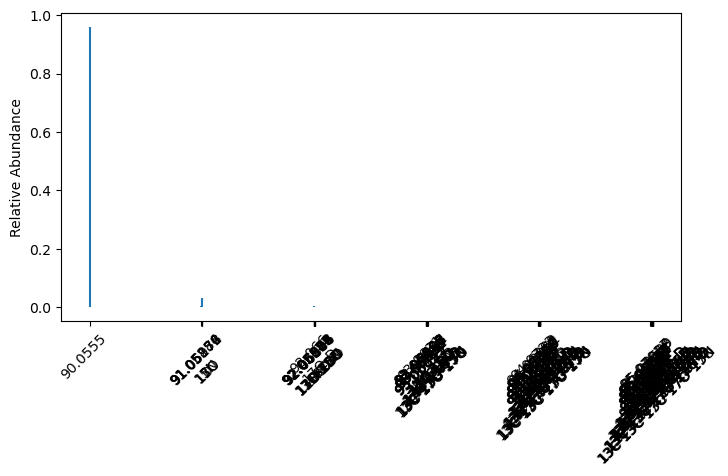

Folder 'Isotopologue tsv files' already exists.


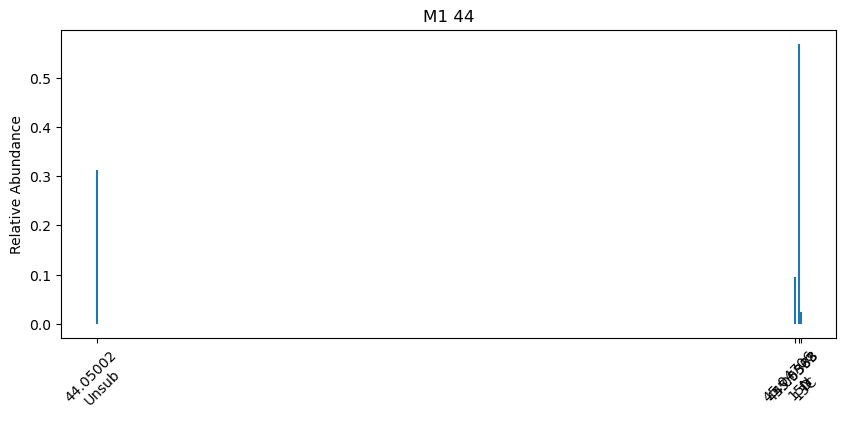

In [6]:
#EXPLORE SYSTEM
#We have extracted out some parameters and created two simplified plots that you can use to visualize the whole molecule,
#and an M+1 fragment example that you can look at as a mass spectrum. Feel free to play around to find what is more interesting to you! In practice, it may help to pull out these plotting functions and working with the code directly. 
FIG_SIZE = (8,4)

#Do you want to output an isotopologues.tsv file that can be used to process data in ISOX? If yes, set this variable below to "True"
OUTPUT_ISOTOPOLOGUES_FILE = True

#Visualize the full mass spectrum of your modeled molecule
spectrumVis.fullSpectrumVis(predictedMeasurement['Full Molecule'], initializedMolecule['molecularDataFrame'], figsize = FIG_SIZE, massError = 0, lowAbundanceCutOff = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)

#Visualize the mass spectrum for one M+1 fragment. You also need to run this code for every fragment in order to get an isotopologues.tsv file for each fragment.
#Set parameters
FRAGMENT_TO_EXPLORE = '44' #change this to be the string of your fragment mass, which was specified in your initial csv file
spectrumVis.MNSpectrumVis(initializedMolecule['molecularDataFrame'], FRAGMENT_TO_EXPLORE, predictedMeasurement, 'M1', MNDict, lowAbundanceCutOff = 0, massError = 0, xlim = (), ylim = (), outputIsotopologs=OUTPUT_ISOTOPOLOGUES_FILE)

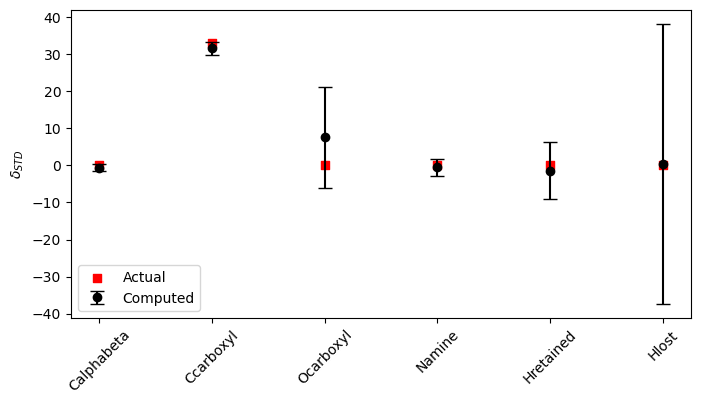

In [7]:
#GET SIMULATION OUTPUT.

#Ok, now we want to simulate a full sample standard comparison. I'll pull up those variables so you can play around with them. Then we have a big function call, which takes in the different variables we specified before. The most interesting to play with will be the STD and SMP_DELTAS. You may also want to mess with the MNError and the UValueError. This plots the actual sample/standard comparison by site and the corresponding errors. 
STD_DELTAS = [-12.9, -10.95, 0, 0, 0, 0]
SMP_DELTAS = [-12.655997165038729, 21.684504860091067, 0, 0, 0, 0]
simulationOutput = sim.simulateSmpStd(os.path.join(cwd, MOLECULE_INPUT_PATH), STD_DELTAS, SMP_DELTAS, STANDARD_DELTA_APPROX, abundanceThreshold = 0, UValueList = [MOLECULAR_AVERAGE_TYPE.split('/')[0]], calcFF = FRACTIONATION, omitMeasurements = OMIT_MEASUREMENTS, ffstd = FRACTIONATION_AMOUNT, errorPath = ERROR_PATH, MNError = MN_ERROR, UValueError = MOLECULAR_AVG_SAMPLE_ERROR, resultsFileName = OUTPUT_FILENAME)

In [8]:
#STEP 3: SET UP TO PROCESS EXPERIMENTAL DATA.

#This next section reads in .isox folders for samples and standards and processes them to get the mean ratios. You may wish to read in and process your data elsewhere using other tools. In that case, you can move on and see the expected format of experimental data, and to use that format.

#SET PARAMETERS FOR THE MEASUREMENT
ACQUISITION_LENGTH = (5, 15) #Change the time here based on what subset of the acquisition you want to include it data processing. 
                                #You can change this based on TIC stability that you investigate in STEP 5 below.

#SET VARIABLES FOR DATA PROCESSING
INPUT_DATA_FOLDER_NAME = 'Input Data' #name the folder that stores inputs to the script
EXPERIMENTAL_DATA_FOLDER_NAME = 'Experimental_Data' #within that folder, there is a second folder for a specific experiment. This will contain nested folders storing sample and standard results for fragments of interest. 
FILE_EXTENSION = '.isox' #set the extension to be whatever format your files are in. Currently, the code handles .isox files but could easily be
                         #adapted to read in other file formats by changing functions in the "dataAnalyzerMNIsoX.py" file
OUTPUT_TO_CSV = True #do you want to output your processed results to csv in 'PROCESSED_DATA_FOLDER_NAME'? If so, set to True.
CSV_OUTPUT_PATH = 'all_data_output.csv' #name what you want that output file to be.

#DETERMINE WHETHER TO RUN AUTOMATED DATA SCREENING
#If True, print a warning for peaks that have moved more than 'PEAK_DRIFT_THRESHOLD' in ppm from their expected position, benchmarked vs the observed position of the most abundant peak. See dataScreenIsoX for details. 
PEAK_DRIFT_SCREEN = True
PEAK_DRIFT_THRESHOLD = 2
#If True, print a warning for peaks that have a proportion of zero scans higher than the threshold. (I.e., more than 0.1% of scans are zero scans if threshold = 0.001)
ZERO_COUNTS_SCREEN = True
ZERO_COUNTS_THRESHOLD = 0
#If True, print a warning for peaks that have RSE/SN > 2. 
RSE_SN_SCREEN = True

In [9]:
#CREATE NESTED FOLDERS TO PUT YOUR DATA INTO FOR PROCESSING
fragmentDictionary = initializedMolecule['fragmentationDictionary']  #create a molecule based on your csv defined a/bove in STEP #1.
new_folder_path = os.path.join(cwd, INPUT_DATA_FOLDER_NAME, EXPERIMENTAL_DATA_FOLDER_NAME) #set up the folder path
folderNames, parent_folder = organizeData.create_nested_folders(fragment_dict=fragmentDictionary, parent_folder=new_folder_path) #create the nested folders

#NOTE: Before moving to the next step, YOU NEED TO PUT YOUR EXPERIMENTAL DATA into the folders created in this step to be able to process

Folder already exists: C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\full
Folder already exists: C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44


In [10]:
#STEP 4: PROCESS ALL DATA
fragmentFolderPaths = organizeData.get_subfolder_paths(parent_folder) #get names of folders for each relevant fragment

#process the data:
rtnMeans, rtnMergedDict = dA.processIndividualAndAverageIsotopeRatios(fragmentFolderPaths, cwd, outputToCSV=OUTPUT_TO_CSV, csvOutputPath = CSV_OUTPUT_PATH, file_extension = FILE_EXTENSION, processed_data_subfolder=INPUT_DATA_FOLDER_NAME, time_bounds = ACQUISITION_LENGTH, peakDriftScreen=PEAK_DRIFT_SCREEN, peakDriftThreshold=PEAK_DRIFT_THRESHOLD, zeroCountsScreen=ZERO_COUNTS_SCREEN, zeroCountsThreshold=ZERO_COUNTS_THRESHOLD, RSESNScreen=RSE_SN_SCREEN)

#Now, your individual acquisition data will be output to a csv at the path you defined above within the "Output data" folder, which you can use to 
#calculate molecular average isotope ratio measurements. in step 5, you can set individual path names to look at TIC variation over the length of an acquisition.

Processing fragment folder: 44
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Smp\20211006_07_Alanine_C1-1_M1_rep1.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Smp\20211006_09_Alanine_C1-1_M1_rep2.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Smp\20211006_11_Alanine_C1-1_M1_rep3.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Std\20211006_06_Alanine_Unlab_M1_rep1.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Std\20211006_08_Alanine_Unlab_M1_rep2.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Std\20211006_10_Alanine_Unlab_M1_rep3.isox
  - C:\Users\tacse\Documents\Isotomics-Automated\Input Data\Experimental_Data\44\Std\20211006_12_Alanine_Unlab_M1_rep4.isox
Processing fragment folder: full_molecular_average
  - C:\Users\tacse\Documents\Isotomics-Automated\Inpu

C:\Users\tacse\Documents\Isotomics-Automated\isotomics\dataScreenIsoX.py:218: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  cAx.legend()


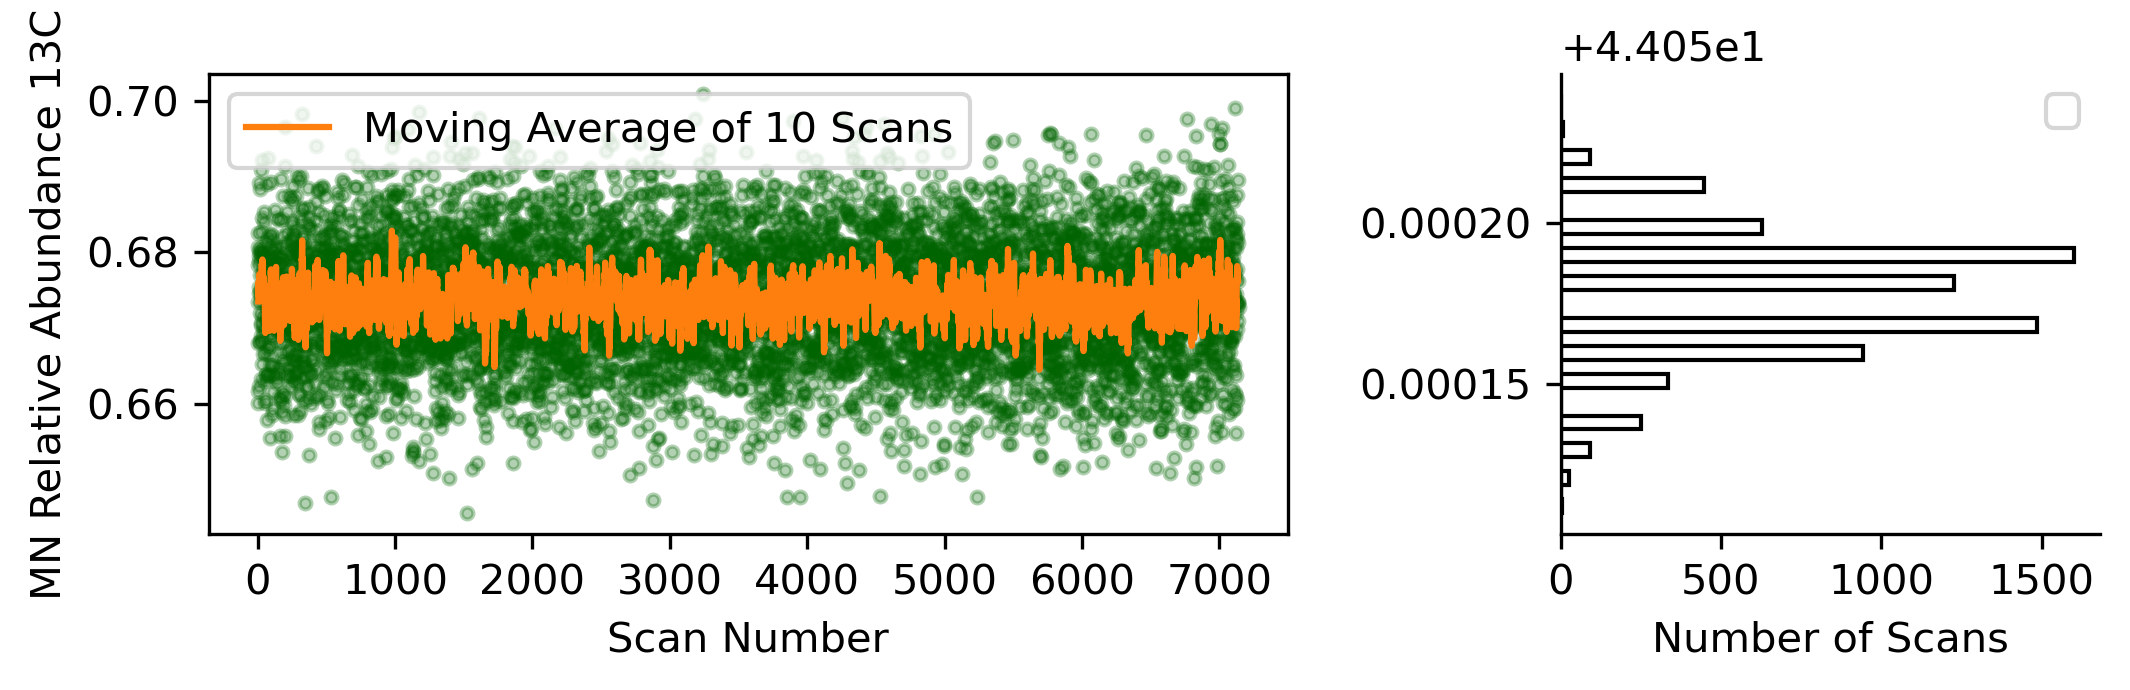

In [11]:
#STEP 5: SCREEN INDIVIDUAL DATA FILES
#This step allows you to copy full path names of each of your data files and visualize what the TIC of that acquistion looks like over time.

SCAN_AVG_NUMBER = 10  # how many scans do you want to calculate tic averages over?
FILEPATH_TO_SCREEN = str(cwd / "Input Data" / "Experimental_Data" / "full_molecular_average" / "Smp" / "20221209_10_TTAS_C1-1_Rep_1.isox")

#for MN Relative Abundance
FILEPATH_TO_SCREEN = str(cwd / "Input Data" / "Experimental_Data" / "44" / "Smp" / "20211006_07_Alanine_C1-1_M1_rep1.isox")

# For ratios like 13C/Unsub:
#dataScreen.visualizeTICVersusTime(
#    fileName=FILEPATH_TO_SCREEN,
#    mergedDict=rtnMergedDict,
#    targetRatio="13C/Unsub",
#    scan_averaging_number=SCAN_AVG_NUMBER,
#)

# For MN Relative Abundance, you can also pass "13C" (or "MN Relative Abundance 13C"):
dataScreen.visualizeTICVersusTime(
     fileName=FILEPATH_TO_SCREEN,
     mergedDict=rtnMergedDict,
     targetRatio="13C",
     scan_averaging_number=SCAN_AVG_NUMBER,
 )


Writing experimental results to CSV: M1Output.csv
CSV write complete.


,IDS,Number,Fragment full,Fragment 44,Standard 1 Delta Values,Standard 2 Delta Values,CRF Deltas,CRF Deltas Error,Relative Deltas,Relative Deltas Error,Standard Delta Values in CRF
Calphabeta,C,2,1,1,-30,-25,-12.050,0.394,-0.151,0.399,-11.90
Ccarboxyl,C,1,1,x,-30,-25,21.693,0.774,31.961,0.782,-9.95
Ocarboxyl,O,2,1,x,0,10,-0.591,15.617,-0.591,15.617,0.00
Namine,N,1,1,1,0,10,-0.711,1.054,-0.711,1.054,0.00
Hretained,H,6,1,1,0,100,1.046,1.257,1.046,1.257,0.00
Hlost,H,2,1,x,0,-100,3.724,14.563,3.724,14.563,0.00


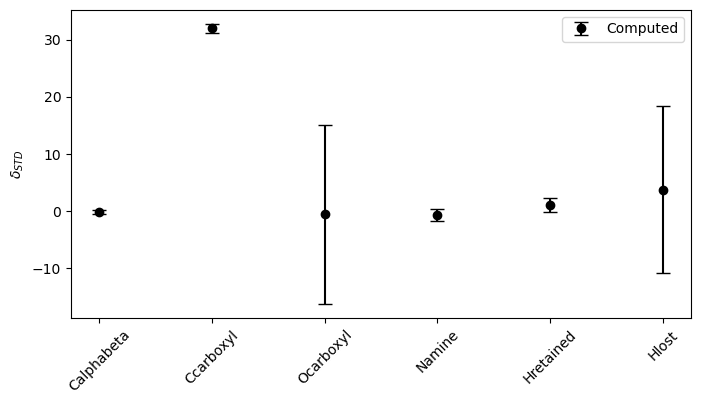

In [12]:
#STEP 6: SOLVE EXPERIMENTAL DATA FOR SITE SPECIFIC VALUES
solveExperimentalData.experimentalDataM1(rtnMeans, cwd, MOLECULE_INPUT_PATH, STANDARD_DELTA_APPROX, UValue = '13C/Unsub', mAObs = MOLECULAR_AVERAGE_SAMPLE_COMPOSITION, mARelErr=MOLECULAR_AVG_SAMPLE_ERROR, perturbTheoryOAmt=0.0003)

Writing experimental results to CSV: M1Output.csv
CSV write complete.


,IDS,Number,Fragment full,Fragment 44,Standard 1 Delta Values,Standard 2 Delta Values,CRF Deltas,CRF Deltas Error,Relative Deltas,Relative Deltas Error,Standard Delta Values in CRF
Calphabeta,C,2,1,1,-30,-25,-12.050,0.394,-0.151,0.399,-11.90
Ccarboxyl,C,1,1,x,-30,-25,21.693,0.774,31.961,0.782,-9.95
Ocarboxyl,O,2,1,x,0,10,-0.591,15.617,-0.591,15.617,0.00
Namine,N,1,1,1,0,10,-0.711,1.054,-0.711,1.054,0.00
Hretained,H,6,1,1,0,100,1.046,1.256,1.046,1.256,0.00
Hlost,H,2,1,x,0,-100,3.724,14.567,3.724,14.567,0.00


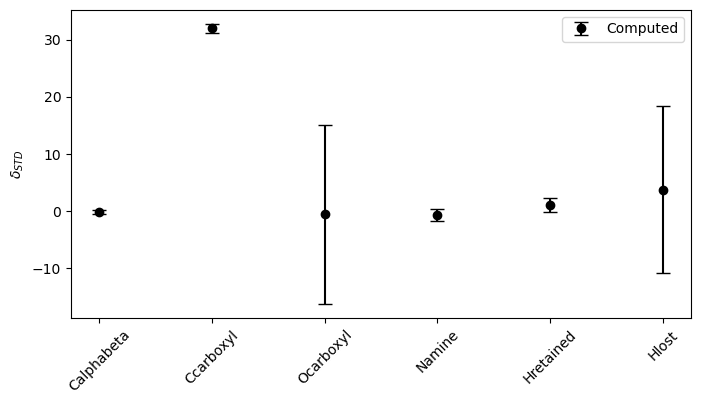

In [13]:
#Step 7 (Optional): If you want to get your input data from another source, i.e. using data processing code you have done yourself or from another source, then you can load in the data. It should be structured as the example .csv.
experimental_data_path = str(cwd / "Input Data" / "Experimental_Data_Input.csv")
experimental_data = pd.read_csv(experimental_data_path)

solveExperimentalData.experimentalDataM1(experimental_data, cwd, MOLECULE_INPUT_PATH, STANDARD_DELTA_APPROX, UValue = '13C/Unsub', mAObs = MOLECULAR_AVERAGE_SAMPLE_COMPOSITION, mARelErr=MOLECULAR_AVG_SAMPLE_ERROR, perturbTheoryOAmt=0.0003)